In [ ]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Ajuste conforme sua pasta RAW
CSV_PATH = "dados_brutos.csv"
if not os.path.exists(CSV_PATH) and os.path.exists("/mnt/data/dados_brutos.csv"):
    CSV_PATH = "/mnt/data/dados_brutos.csv"

df_raw = pd.read_csv(CSV_PATH)

# Trabalhe sempre em uma cópia para análises/derivações em memória
df = df_raw.copy()

# Remove espaços nos nomes das colunas (evita bugs do tipo " month")
df.columns = df.columns.astype(str).str.strip()

def missing_matrix(data: pd.DataFrame) -> pd.DataFrame:
    """True onde o valor é considerado faltante (NaN ou string vazia/espacos em colunas textuais)."""
    m = data.isna()
    obj = data.select_dtypes(include="object").columns
    if len(obj) > 0:
        m.loc[:, obj] |= data[obj].fillna("").astype(str).apply(lambda s: s.str.strip().eq(""))
    return m

def to_num(s: pd.Series) -> pd.Series:
    """Converte para número (apenas em memória)."""
    return pd.to_numeric(s, errors="coerce")

print("Shape:", df.shape)

Shape: (279182, 22)


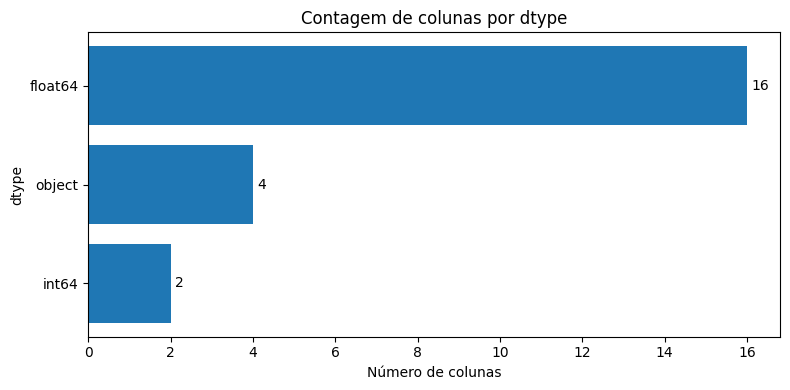

In [2]:
# ============================================================
# 1) Contagem de colunas por dtype (checkpoint de schema)
# ============================================================

dtype_counts = df.dtypes.value_counts().sort_values()

fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.barh(dtype_counts.index.astype(str), dtype_counts.values)

ax.set_title("Contagem de colunas por dtype")
ax.set_xlabel("Número de colunas")
ax.set_ylabel("dtype")

ax.bar_label(bars, padding=3)
plt.tight_layout()
plt.show()

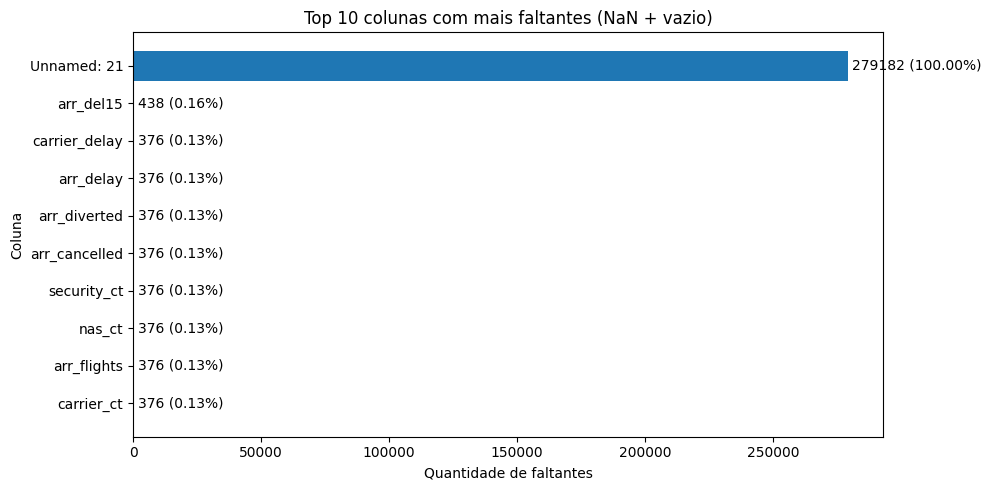

In [3]:
# ============================================================
# 2a) Top 10 colunas com mais faltantes (NaN + vazio)
# ============================================================

m = missing_matrix(df)
counts = m.sum().sort_values(ascending=False)
pct = (counts / len(df)) * 100

top10 = (
    pd.DataFrame({"faltantes_qtd": counts, "faltantes_pct": pct})
      .head(10)
      .sort_values("faltantes_qtd", ascending=True)
)

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(top10.index, top10["faltantes_qtd"])

ax.set_title("Top 10 colunas com mais faltantes (NaN + vazio)")
ax.set_xlabel("Quantidade de faltantes")
ax.set_ylabel("Coluna")

labels = [f"{int(q)} ({p:.2f}%)" for q, p in zip(top10["faltantes_qtd"], top10["faltantes_pct"])]
ax.bar_label(bars, labels=labels, padding=3)

plt.tight_layout()
plt.show()

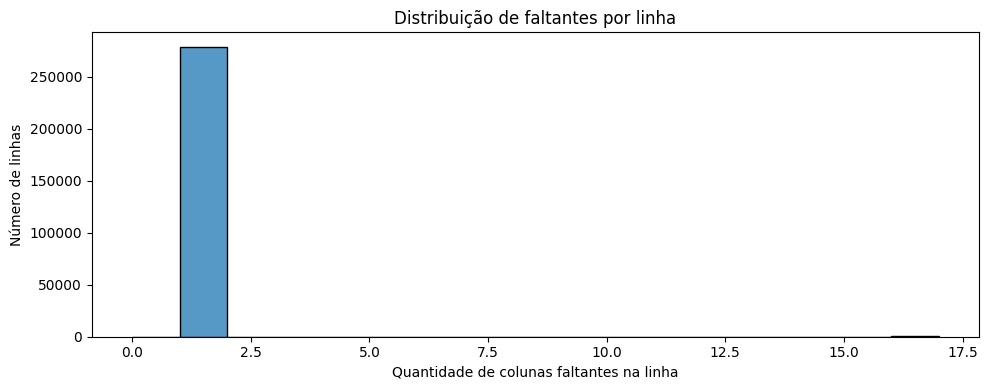

In [4]:
# ============================================================
# 2b) Histograma de faltantes por linha (complemento do 2a)
# ============================================================

missing_per_row = m.sum(axis=1)

fig, ax = plt.subplots(figsize=(10, 4))
sns.histplot(missing_per_row, bins=range(0, int(missing_per_row.max()) + 2), ax=ax)

ax.set_title("Distribuição de faltantes por linha")
ax.set_xlabel("Quantidade de colunas faltantes na linha")
ax.set_ylabel("Número de linhas")

plt.tight_layout()
plt.show()

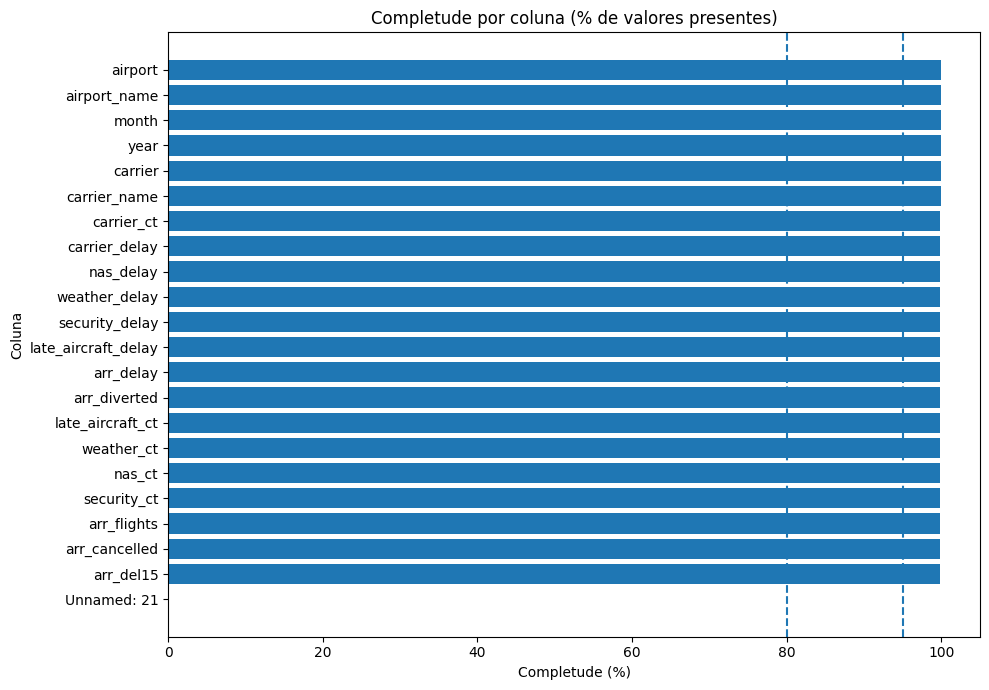

In [5]:
# ============================================================
# 3) Completude por coluna (% presentes) + thresholds 80% e 95%
# ============================================================

completude = (1 - m.mean()) * 100
comp_tbl = completude.sort_values().to_frame("completude_pct")

fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.barh(comp_tbl.index, comp_tbl["completude_pct"].values)

ax.set_title("Completude por coluna (% de valores presentes)")
ax.set_xlabel("Completude (%)")
ax.set_ylabel("Coluna")

ax.axvline(80, linestyle="--")
ax.axvline(95, linestyle="--")

plt.tight_layout()
plt.show()

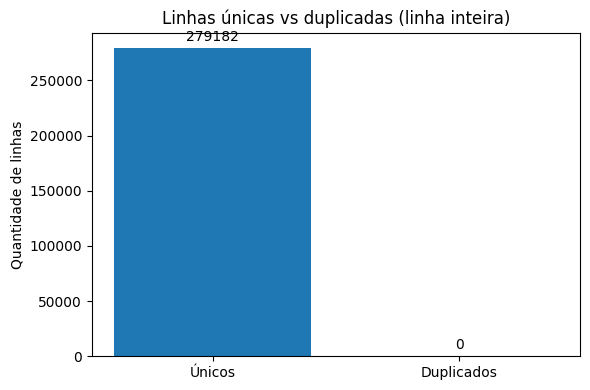

In [6]:
# ============================================================
# 4) Duplicados (linha inteira): únicos vs duplicados
# ============================================================

dup = int(df.duplicated().sum())
unique = int(len(df) - dup)

plot_df = pd.DataFrame(
    {"categoria": ["Únicos", "Duplicados"], "qtd": [unique, dup]}
)

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(plot_df["categoria"], plot_df["qtd"])

ax.set_title("Linhas únicas vs duplicadas (linha inteira)")
ax.set_xlabel("")
ax.set_ylabel("Quantidade de linhas")

ax.bar_label(bars, padding=3)
plt.tight_layout()
plt.show()

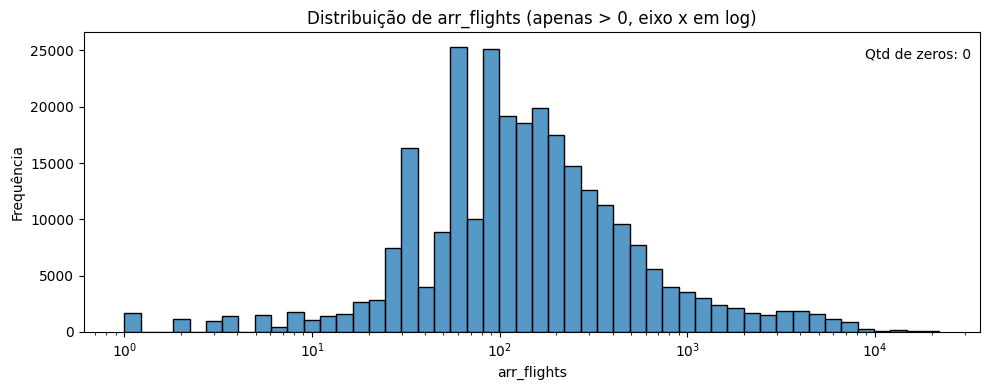

In [7]:
# ============================================================
# 5) Distribuição de arr_flights (histograma em escala log no eixo x)
# ============================================================

arr_flights = to_num(df.get("arr_flights"))
zeros = int((arr_flights == 0).sum()) if arr_flights is not None else 0

fig, ax = plt.subplots(figsize=(10, 4))
sns.histplot(arr_flights[arr_flights > 0].dropna(), bins=50, log_scale=True, ax=ax)

ax.set_title("Distribuição de arr_flights (apenas > 0, eixo x em log)")
ax.set_xlabel("arr_flights")
ax.set_ylabel("Frequência")

ax.text(0.99, 0.95, f"Qtd de zeros: {zeros}", transform=ax.transAxes, ha="right", va="top")

plt.tight_layout()
plt.show()

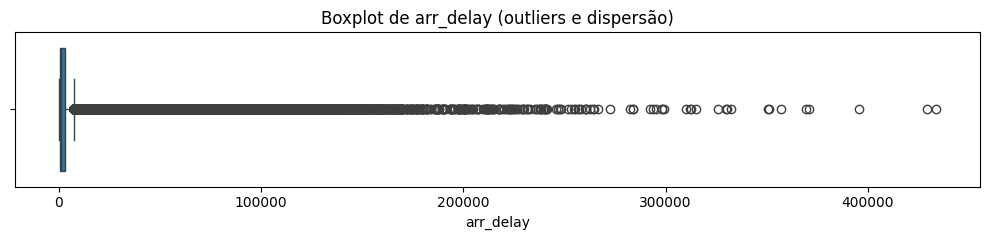

In [8]:
# ============================================================
# 6) Outliers em arr_delay (boxplot)
# ============================================================

arr_delay = to_num(df.get("arr_delay"))

fig, ax = plt.subplots(figsize=(10, 2.5))
sns.boxplot(x=arr_delay.dropna(), ax=ax)

ax.set_title("Boxplot de arr_delay (outliers e dispersão)")
ax.set_xlabel("arr_delay")
ax.set_ylabel("")

plt.tight_layout()
plt.show()


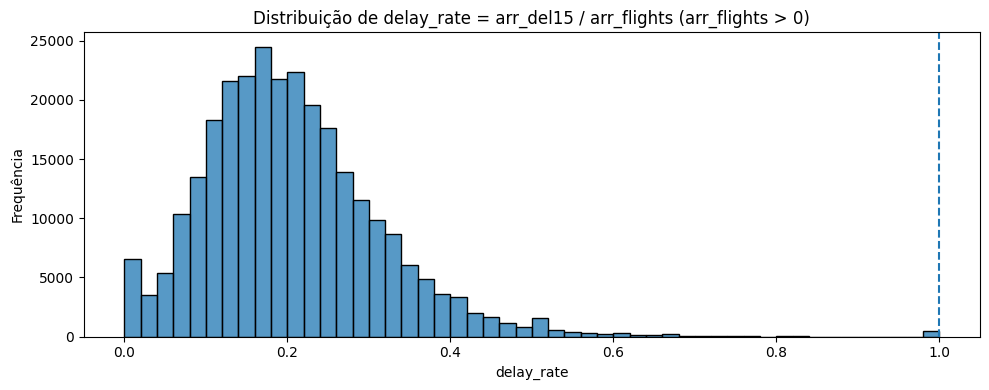

In [9]:
# ============================================================
# 7) Integridade via delay_rate = arr_del15 / arr_flights
# ============================================================

arr_del15 = to_num(df.get("arr_del15"))
arr_flights = to_num(df.get("arr_flights"))

valid = (arr_flights > 0) & arr_flights.notna() & arr_del15.notna()
delay_rate = (arr_del15[valid] / arr_flights[valid]).dropna()

fig, ax = plt.subplots(figsize=(10, 4))
sns.histplot(delay_rate, bins=50, ax=ax)

ax.set_title("Distribuição de delay_rate = arr_del15 / arr_flights (arr_flights > 0)")
ax.set_xlabel("delay_rate")
ax.set_ylabel("Frequência")

ax.axvline(1.0, linestyle="--")  # acima disso é incoerente por definição
plt.tight_layout()
plt.show()


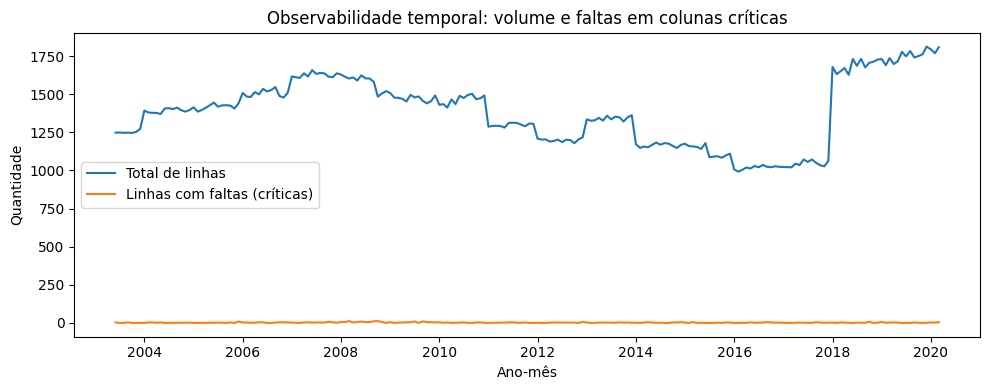

In [10]:
# ============================================================
# 8) Observabilidade temporal (QA): volume e linhas com faltas em colunas críticas
# ============================================================

year = to_num(df.get("year"))
month = to_num(df.get("month"))

period = pd.to_datetime(
    {"year": year, "month": month, "day": 1},
    errors="coerce"
)

critical_cols = [
    "arr_flights", "arr_del15", "arr_delay",
    "carrier_delay", "weather_delay", "nas_delay", "security_delay", "late_aircraft_delay",
    "arr_cancelled", "arr_diverted"
]
critical_cols = [c for c in critical_cols if c in df.columns]

m_critical = missing_matrix(df[critical_cols]) if critical_cols else pd.DataFrame(index=df.index)
rows_with_missing_critical = m_critical.any(axis=1) if critical_cols else pd.Series(False, index=df.index)

ts = (
    pd.DataFrame({
        "period": period,
        "total_rows": 1,
        "rows_missing_critical": rows_with_missing_critical.astype(int)
    })
    .dropna(subset=["period"])
    .groupby("period", as_index=False)
    .agg(total_rows=("total_rows", "sum"),
         rows_missing_critical=("rows_missing_critical", "sum"))
    .sort_values("period")
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(ts["period"], ts["total_rows"], label="Total de linhas")
ax.plot(ts["period"], ts["rows_missing_critical"], label="Linhas com faltas (críticas)")

ax.set_title("Observabilidade temporal: volume e faltas em colunas críticas")
ax.set_xlabel("Ano-mês")
ax.set_ylabel("Quantidade")

ax.legend()
plt.tight_layout()
plt.show()
